#### Выгрузка данных и первичный анализ

In [1]:
from dotenv import load_dotenv
import os
import requests as rq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

v = rq.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

visits = pd.DataFrame(v.json())
regs = pd.DataFrame(r.json())

# Конверсия

#### Очистка датасетов

In [48]:
visits = visits.drop(visits[visits['platform'] == 'bot'].index)
visits_last = visits.sort_values('datetime').groupby('visit_id').tail(1)

#### Объединение данных визитов и регистраций по дате и платформе

In [63]:
visits_last['date_group'] = pd.to_datetime(visits['datetime']).dt.date
visits_agr = visits_last.drop(['datetime', 'user_agent'], axis=1)
visits_agr = visits_agr.groupby(['date_group', 'platform']).agg(visits = ('visit_id', 'count'))
visits_agr = visits_agr.reset_index()

regs['date_group'] = pd.to_datetime(regs['datetime']).dt.date
regs_agr = regs.drop(['datetime', 'email', 'registration_type'], axis=1)
regs_agr = regs_agr.groupby(['date_group', 'platform']).agg(registrations = ('user_id', 'count'))
regs_agr = regs_agr.reset_index()

#### Расчет конверсии

In [5]:
convers = pd.merge(left=visits_agr, right=regs_agr, on=('date_group', 'platform'))
convers['conversion'] = convers['registrations'] * 100 / convers['visits']

In [6]:
convers.to_json('./conversion.json')

# Реклама

In [7]:
ads = pd.read_csv('ads.csv')

ads['date_group'] = pd.to_datetime(ads['date']).dt.date
ads = ads.drop(['date', 'utm_source', 'utm_medium'], axis=1)

convers_cut = convers.drop(['platform', 'conversion'], axis=1)
ads_full = pd.merge(convers_cut, ads, on='date_group')
ads_full['cost'] =ads_full['cost'].fillna(0)
ads_full['utm_campaign'] =ads_full['utm_campaign'].fillna('none')

conv_ads = pd.merge(convers, ads_full, on=('date_group', 'visits', 'registrations'))

In [8]:
conv_ads.to_json('./ads.json')

# Визуализация

#### Подготовка данных

In [9]:
visits_agr = visits_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()

convers['conversion'] = convers['conversion'].astype(int)

regs_agr = regs_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()

over_conv = convers.drop(['conversion', 'platform'], axis=1).groupby('date_group').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum')).reset_index()
over_conv['conversion'] = round(over_conv['registrations'] / over_conv['visits']  * 100, 2)
over_conv = over_conv.drop(['visits', 'registrations'], axis = 1)
over_conv['conversion'] = over_conv['conversion'].astype(int)

android_conv = convers.iloc[0::3].drop(['platform', 'visits', 'registrations'], axis=1)
ios_conv = convers.iloc[1::3].drop(['platform', 'visits', 'registrations'], axis=1)
web_conv = convers.iloc[2::3].drop(['platform', 'visits', 'registrations'], axis=1)

ads_graph = ads.drop(['utm_campaign'], axis=1)

vis_ads_utm = conv_ads.drop(['platform', 'registrations', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(visits = ('visits', 'sum')).reset_index()
vis_ads_utm['average'] = round(vis_ads_utm['visits'].mean())

utm = (vis_ads_utm.groupby(['utm_campaign'], as_index=False)
        .agg(**{'first':('date_group', 'first'),
                'last': ('date_group', 'last')}))

reg_ads_utm = conv_ads.drop(['platform', 'visits', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(registrations = ('registrations', 'sum')).reset_index()
reg_ads_utm['average'] = round(reg_ads_utm['registrations'].mean())

#### График общих визитов

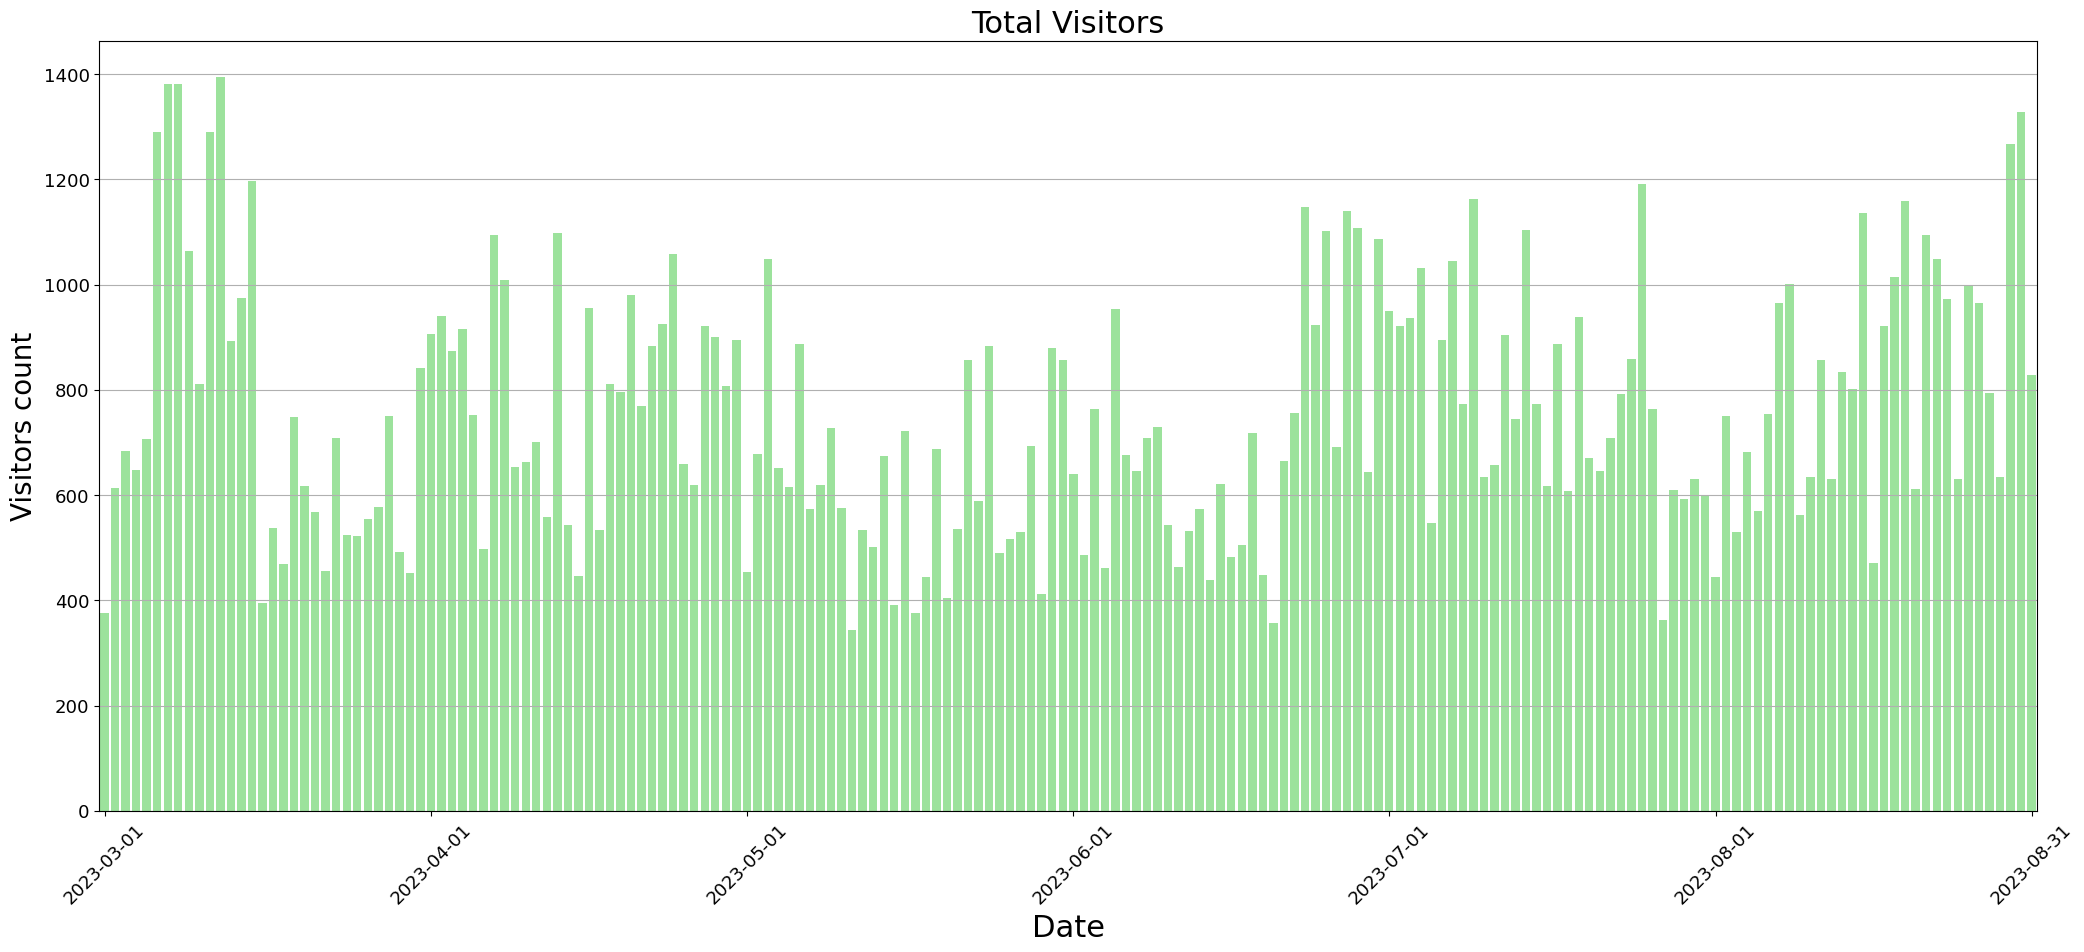

In [35]:
def graph(df, x, y, color, x_label, y_label, title):
    plt.figure(figsize=(25,10))
    splot = sns.barplot(data=df, x=x, y=y, color=color, errorbar = None)
    plt.xlabel(x_label, size=22)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid(axis='y')
    #plt.bar_label(splot.containers[0], size=12)

graph(visits_agr, 'date_group', 'visits', 'lightgreen', 'Date', 'Visitors count', 'Total Visitors')

plt.savefig('./charts/visits_by_date.png')
plt.show()

#### Визиты по платформам

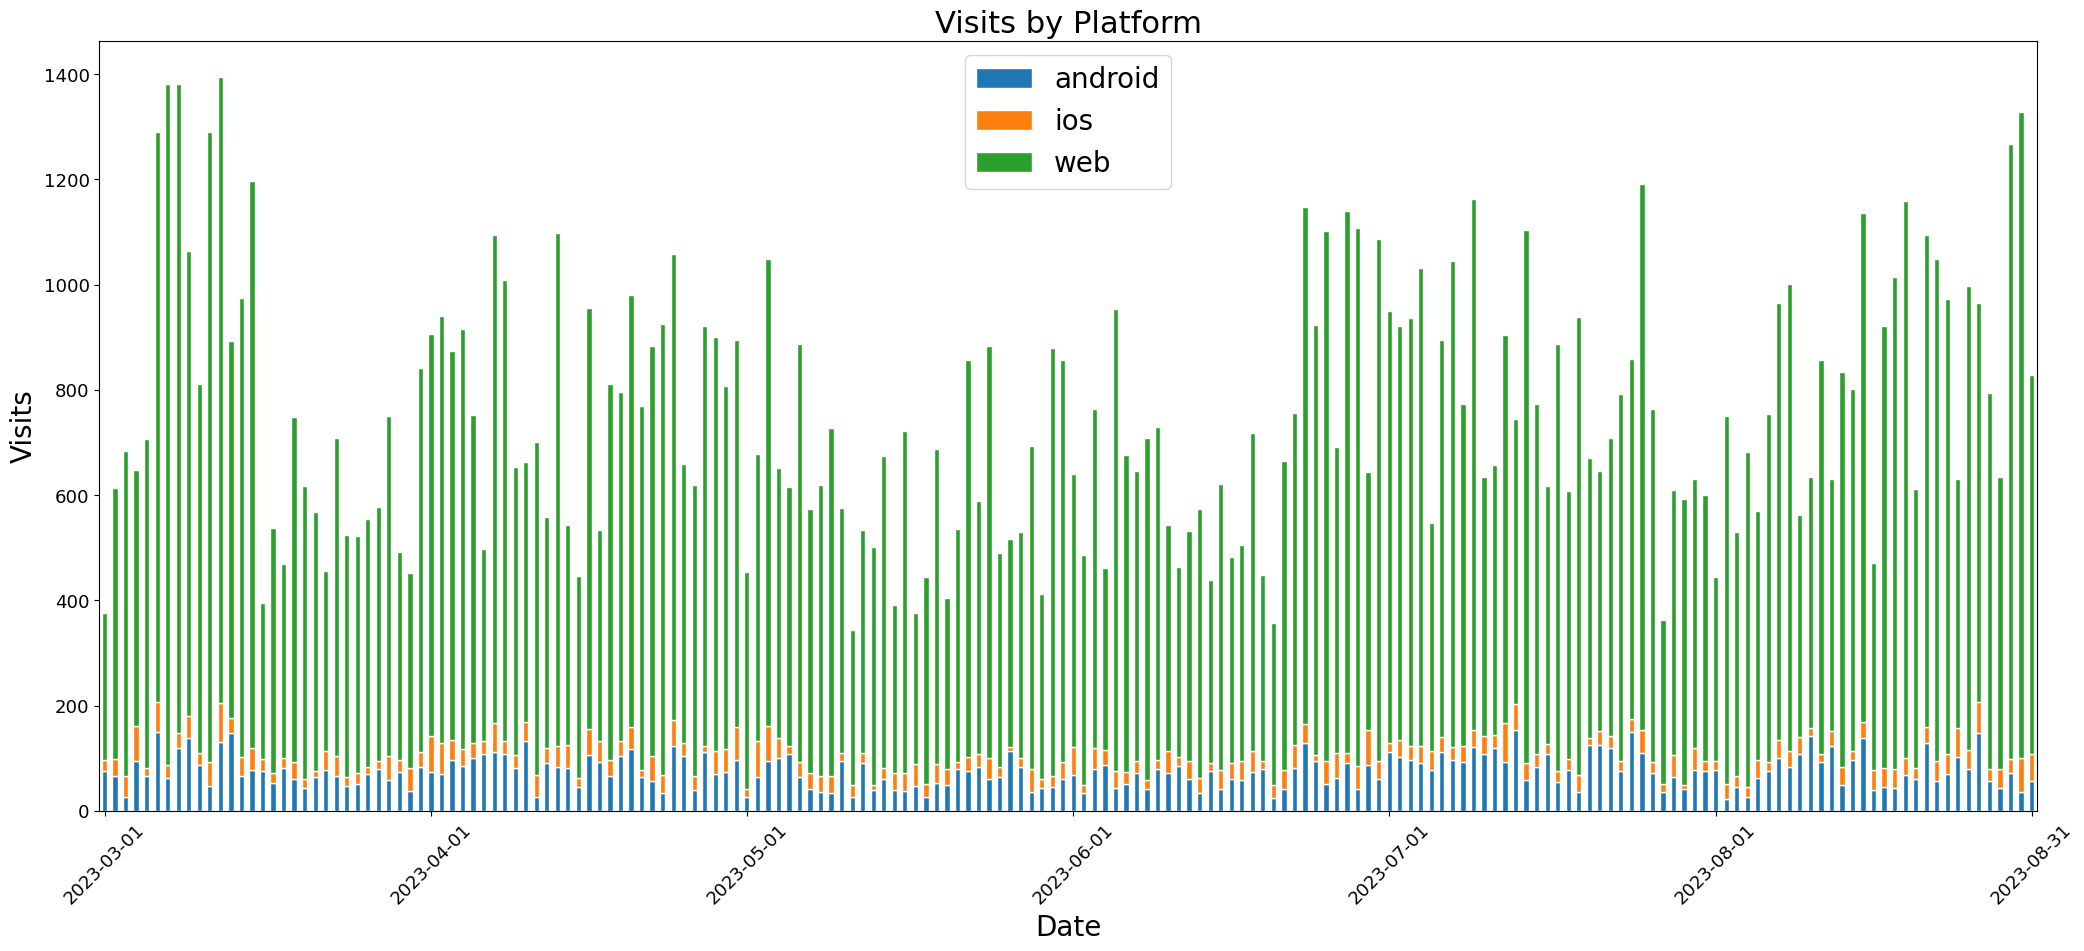

In [13]:
def stack_graph(x, y, x_label, y_label, title):
    con = convers.pivot_table(values=y, index=x, columns='platform', aggfunc='sum', fill_value=0)
    fig, ax = plt.subplots(figsize=(25, 10))
    con.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')
    ax.set_xlabel(x_label, size=20)
    ax.set_ylabel(y_label, size=20)
    ax.set_title(title, size=22)
    plt.yticks(size=13)
    plt.legend(fontsize=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)

stack_graph('date_group', 'visits', 'Date', 'Visits', 'Visits by Platform')

plt.savefig('./charts/visits_by_platform.png')
plt.show()

#### График регистраций

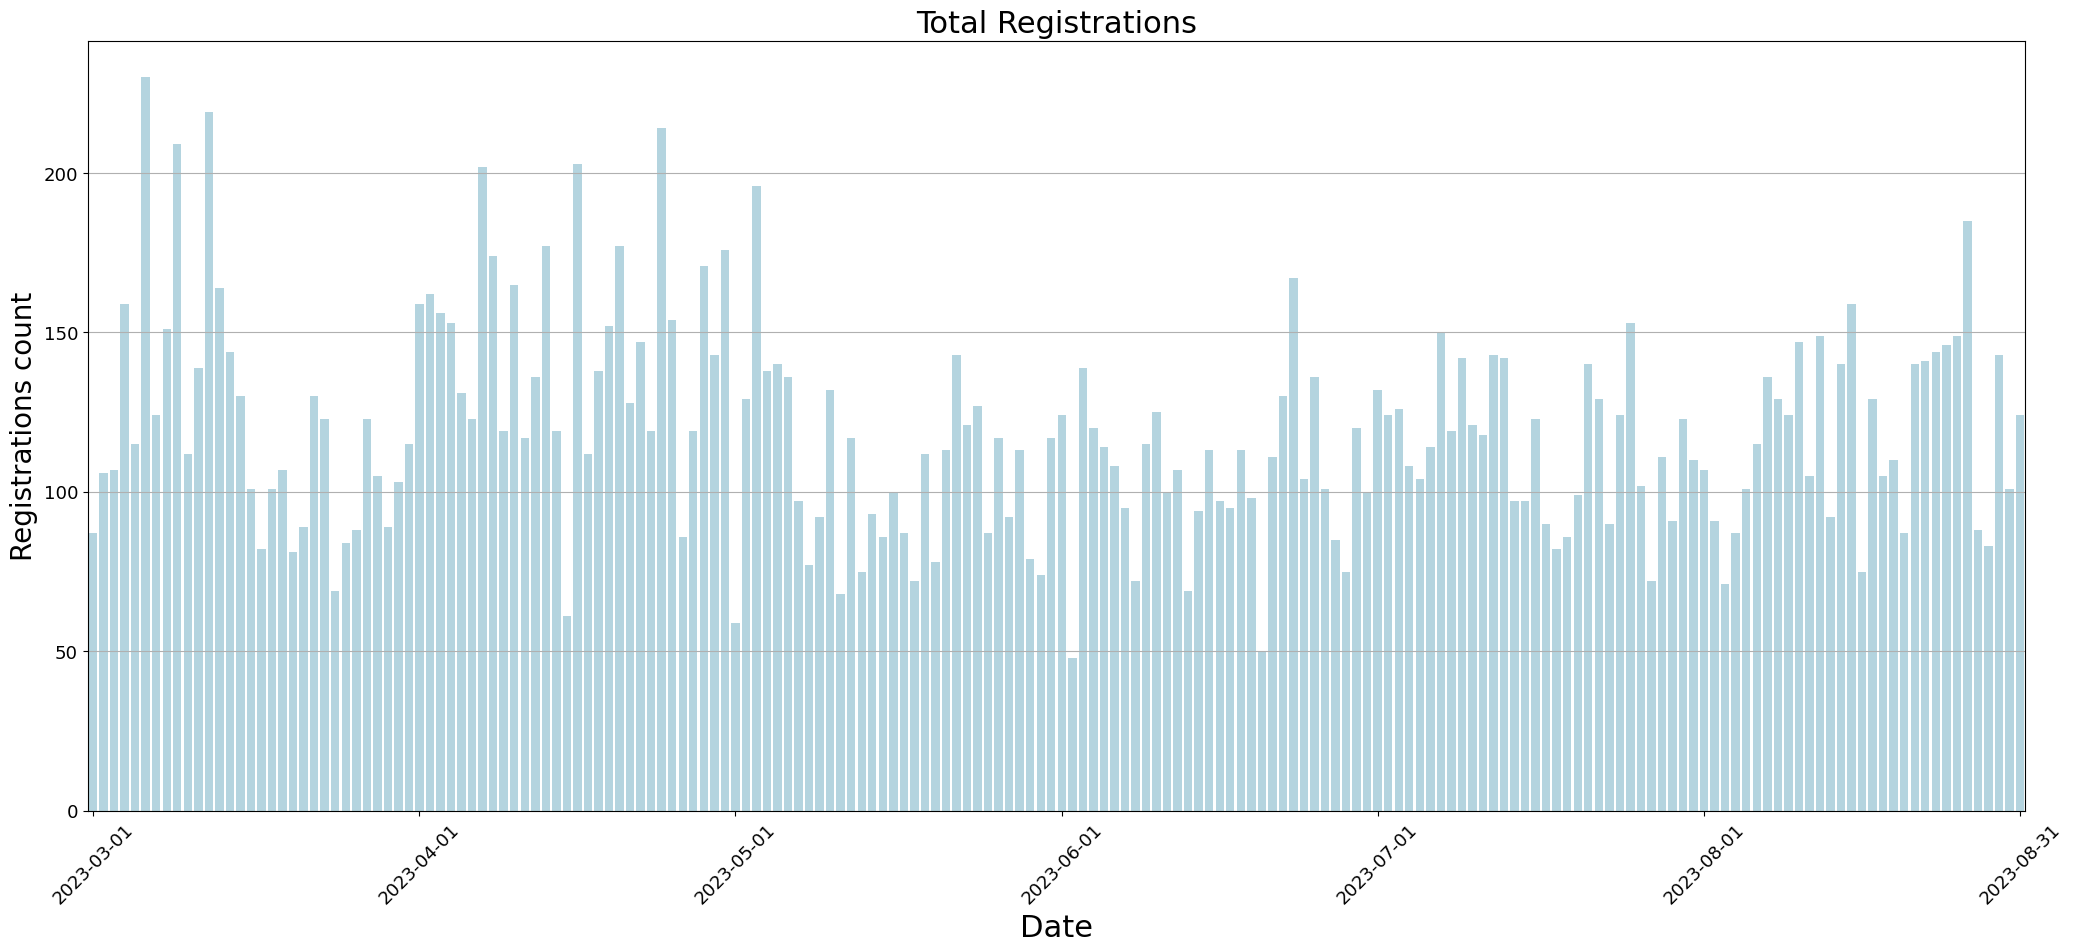

In [36]:
graph(regs_agr, 'date_group', 'registrations', 'lightblue', 'Date', 'Registrations count', 'Total Registrations')

plt.savefig('./charts/registrations_by_date.png')
plt.show()

#### Регистрации по платформам

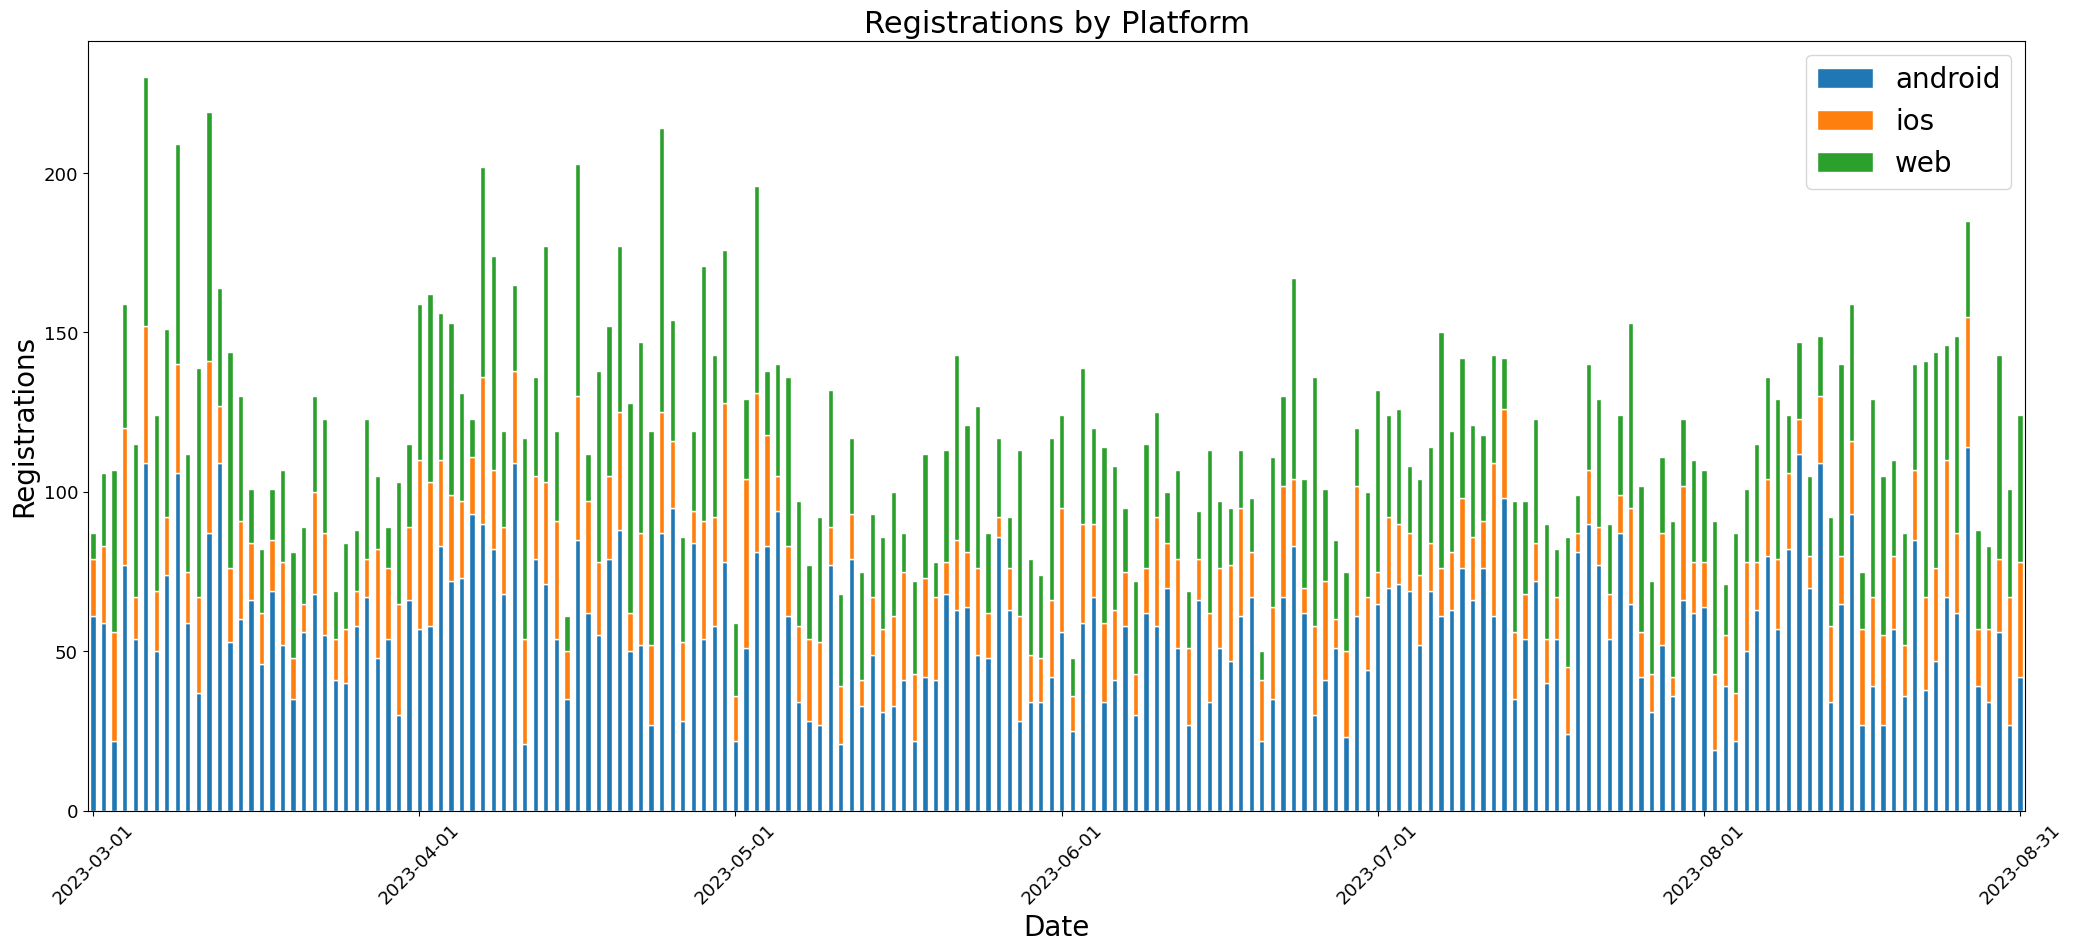

In [14]:
stack_graph('date_group', 'registrations', 'Date', 'Registrations', 'Registrations by Platform')

plt.savefig('./charts/registrations_by_platform.png')
plt.show()

#### Общая конверсия

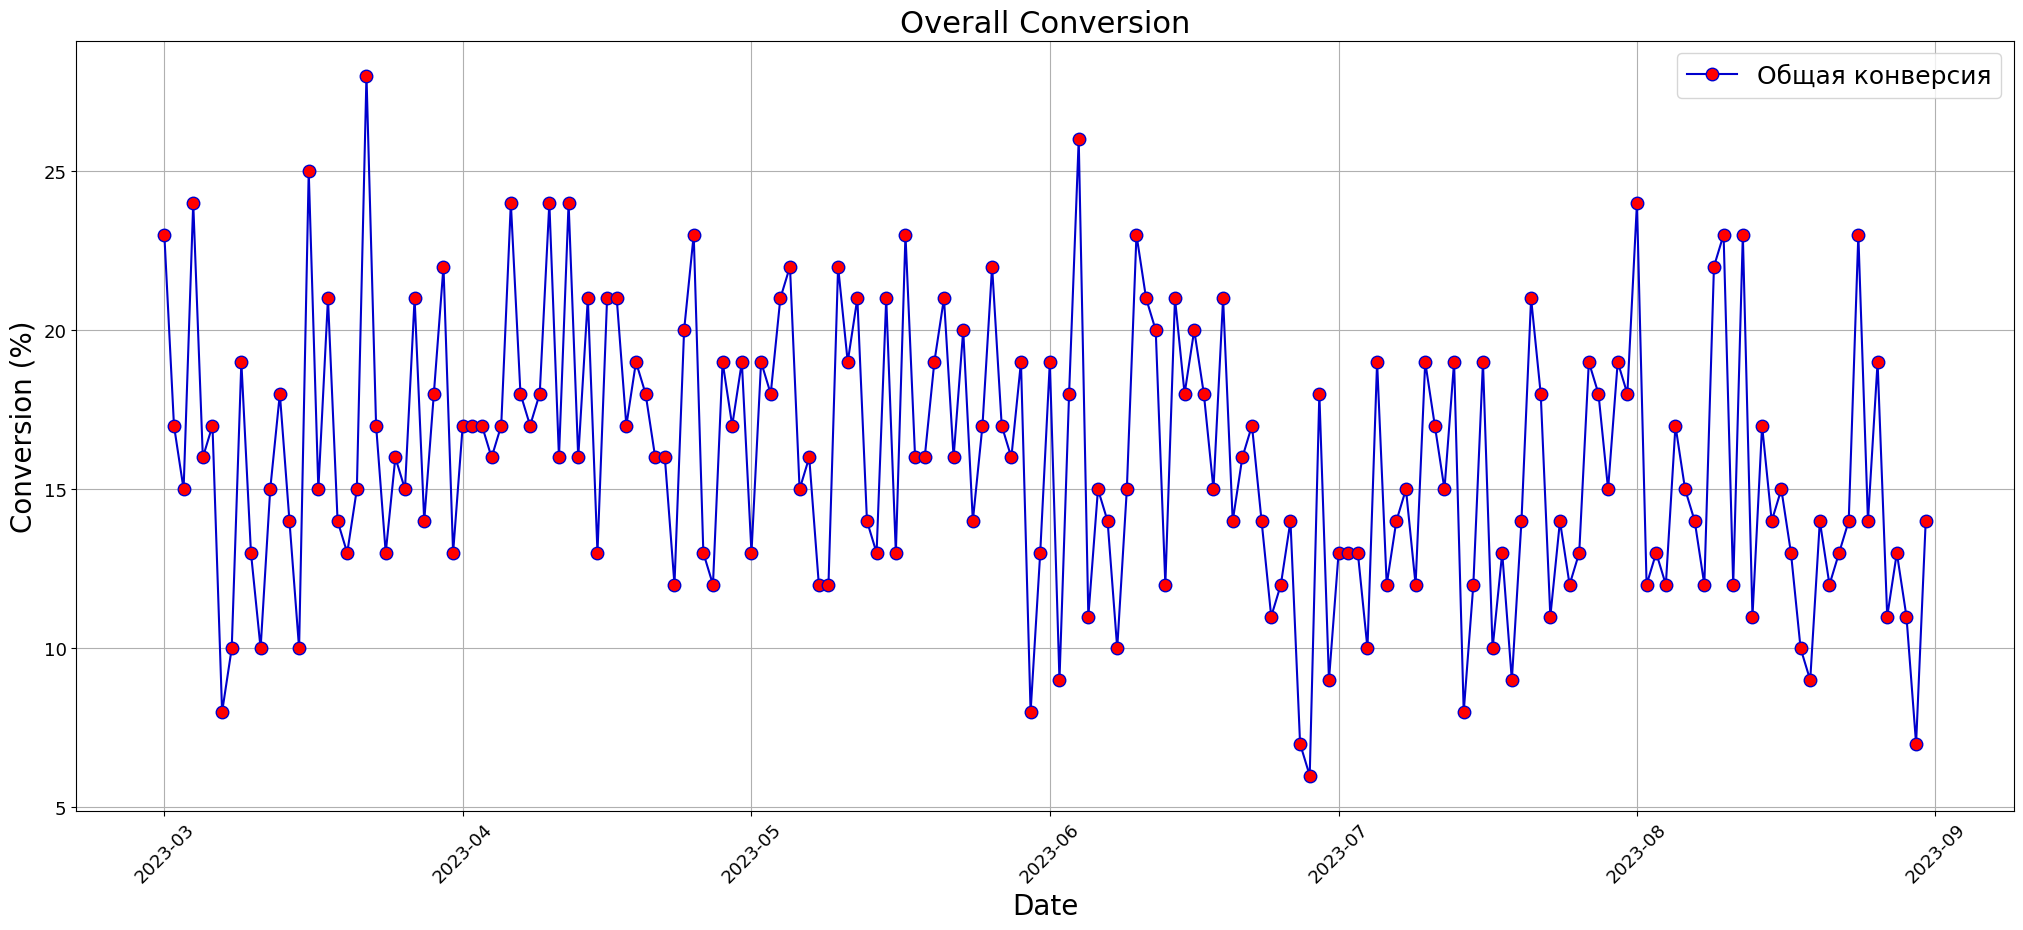

In [34]:
def conv_graph(x, y, df, color, label, x_label, y_label, title):
    plt.figure(figsize=(25, 10))

    plt.plot(x, y, data=df, marker='o', markersize = 9, color=color, markerfacecolor='r', label=label)

    plt.xlabel(x_label, size=20)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x][i], df[y][i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)

conv_graph('date_group', 'conversion', over_conv, 'mediumblue', 'Общая конверсия',
           'Date', 'Conversion (%)', 'Overall Conversion')
           
plt.savefig('./charts/overall_conversion.png')
plt.show()

#### Конверсия по платформам

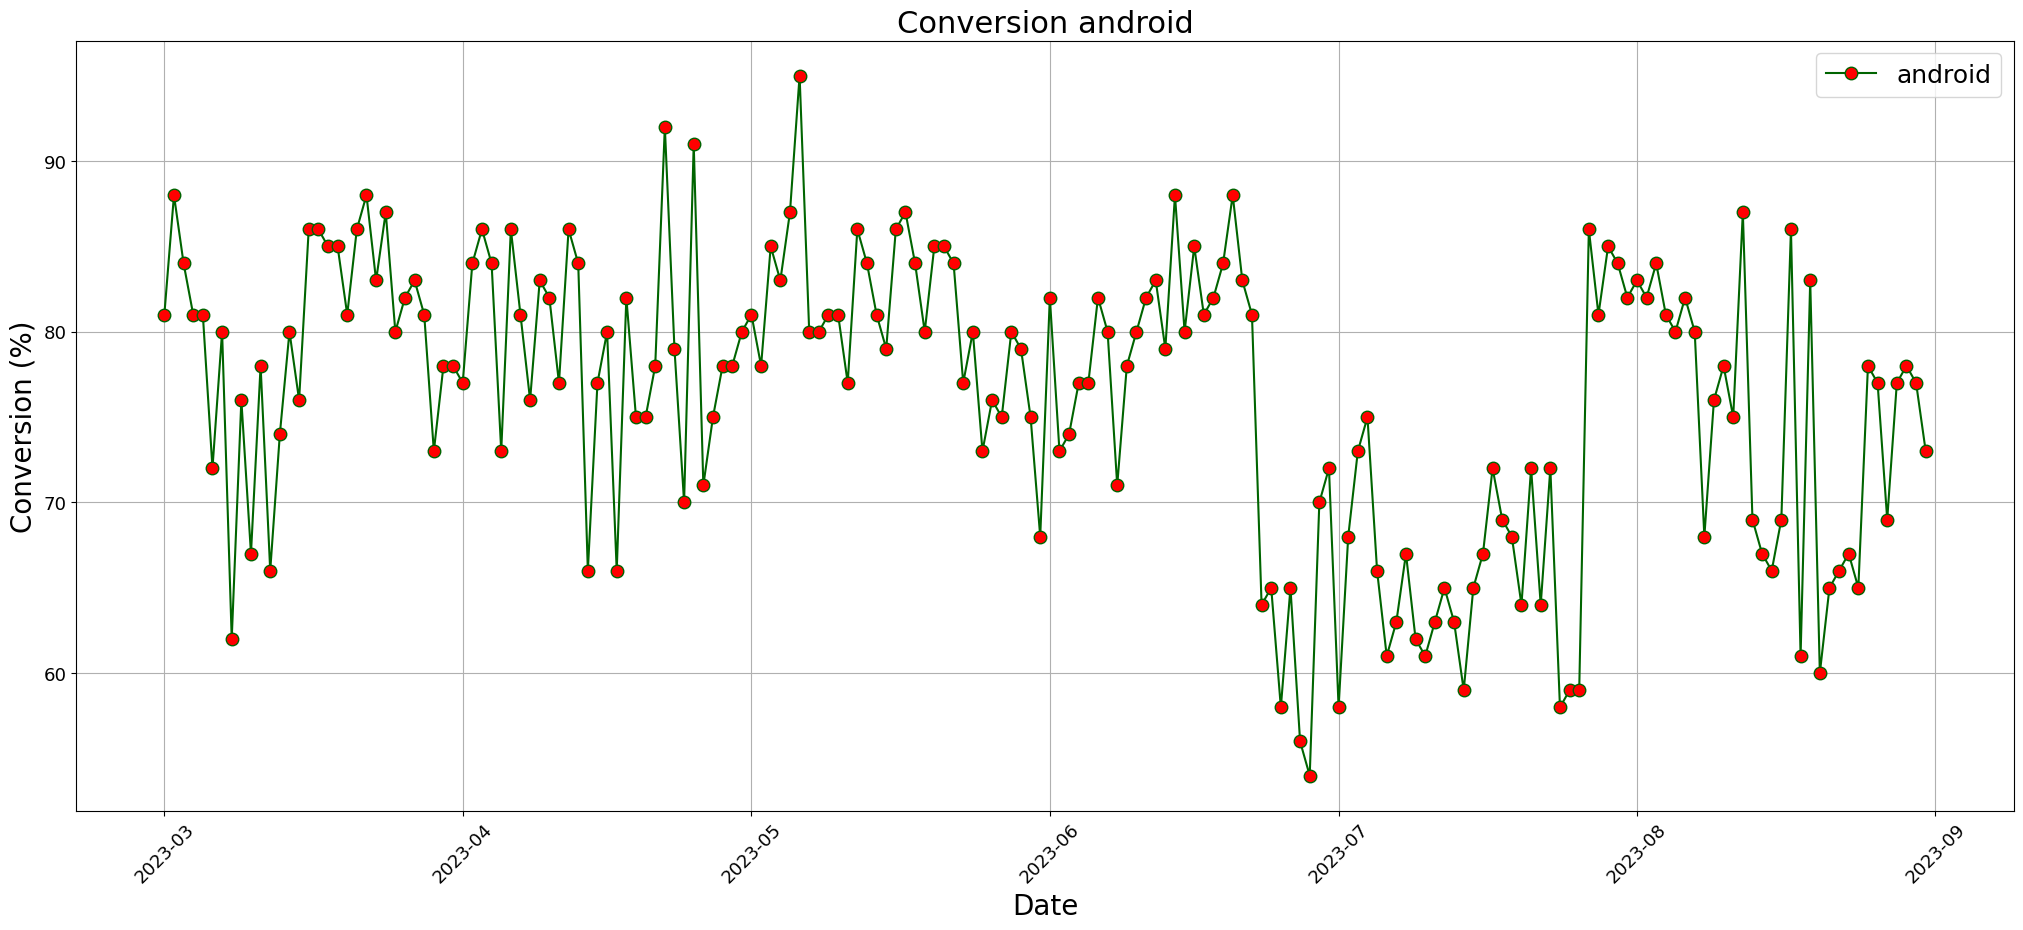

In [31]:
def plat_conv_graph(x, y, df, color, label, x_label, y_label, title):
    plt.figure(figsize=(25, 10))

    plt.plot(x, y, data=df, marker='o', markersize = 9, color=color, markerfacecolor='r', label=label)

    plt.xlabel(x_label, size=20)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x].iloc[i], df[y].iloc[i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)

plat_conv_graph('date_group', 'conversion', android_conv, 'darkgreen', 'android',
           'Date', 'Conversion (%)', 'Conversion android')

plt.savefig('./charts/android_conversion.png')
plt.show()

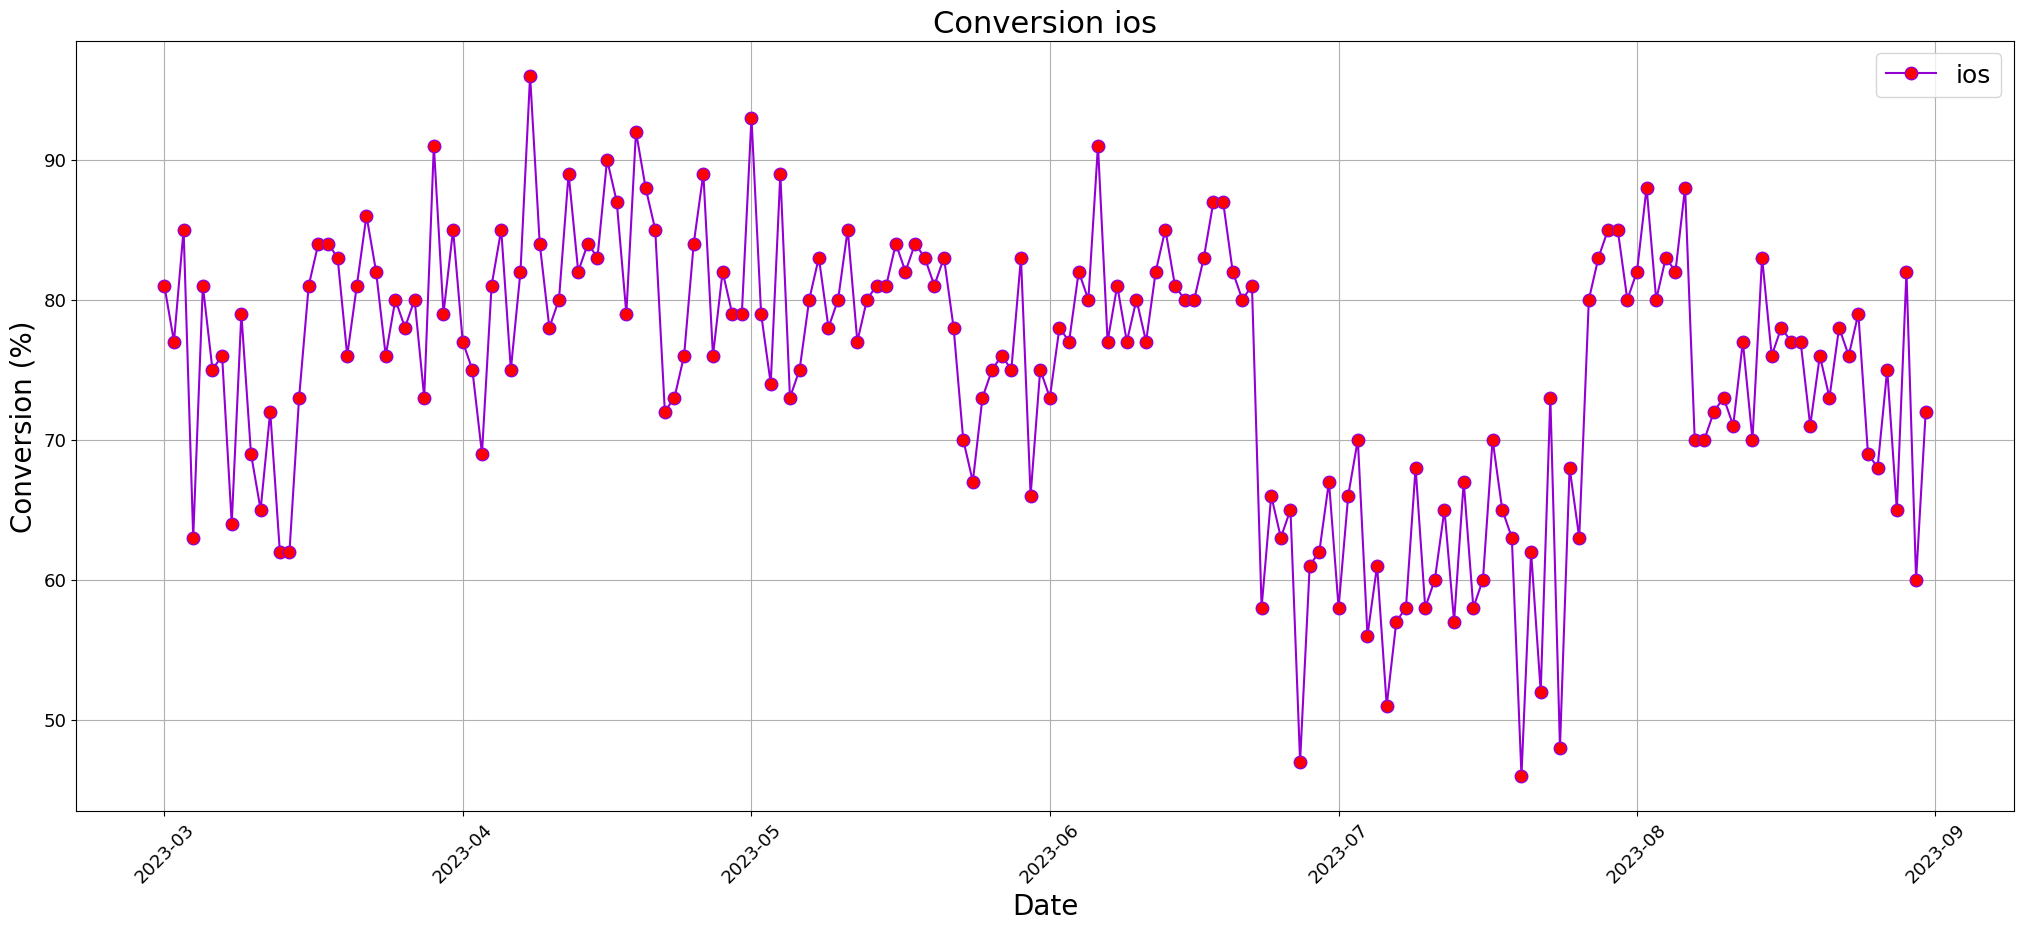

In [32]:
plat_conv_graph('date_group', 'conversion', ios_conv, 'darkviolet', 'ios',
           'Date', 'Conversion (%)', 'Conversion ios')

plt.savefig('./charts/ios_conversion.png')
plt.show()

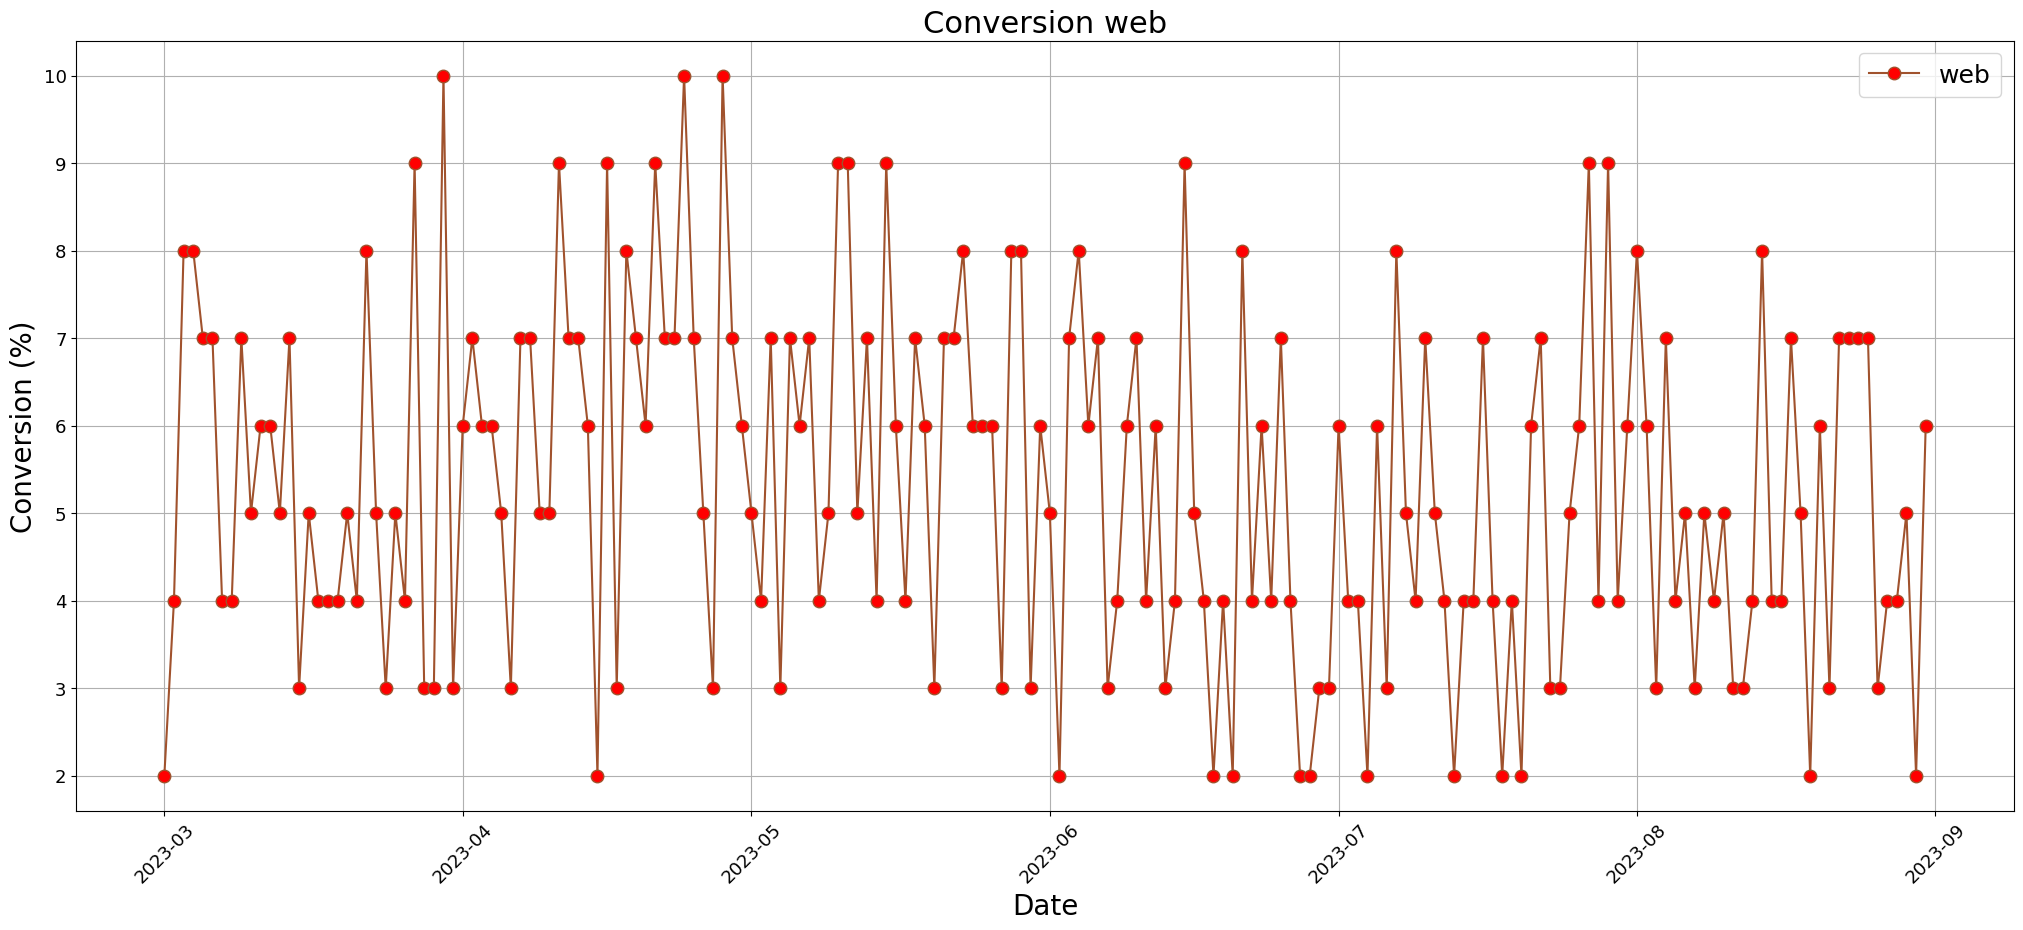

In [33]:
plat_conv_graph('date_group', 'conversion', web_conv, 'sienna', 'web',
           'Date', 'Conversion (%)', 'Conversion web')

plt.savefig('./charts/web_conversion.png')
plt.show()

#### Стоимость рекламы

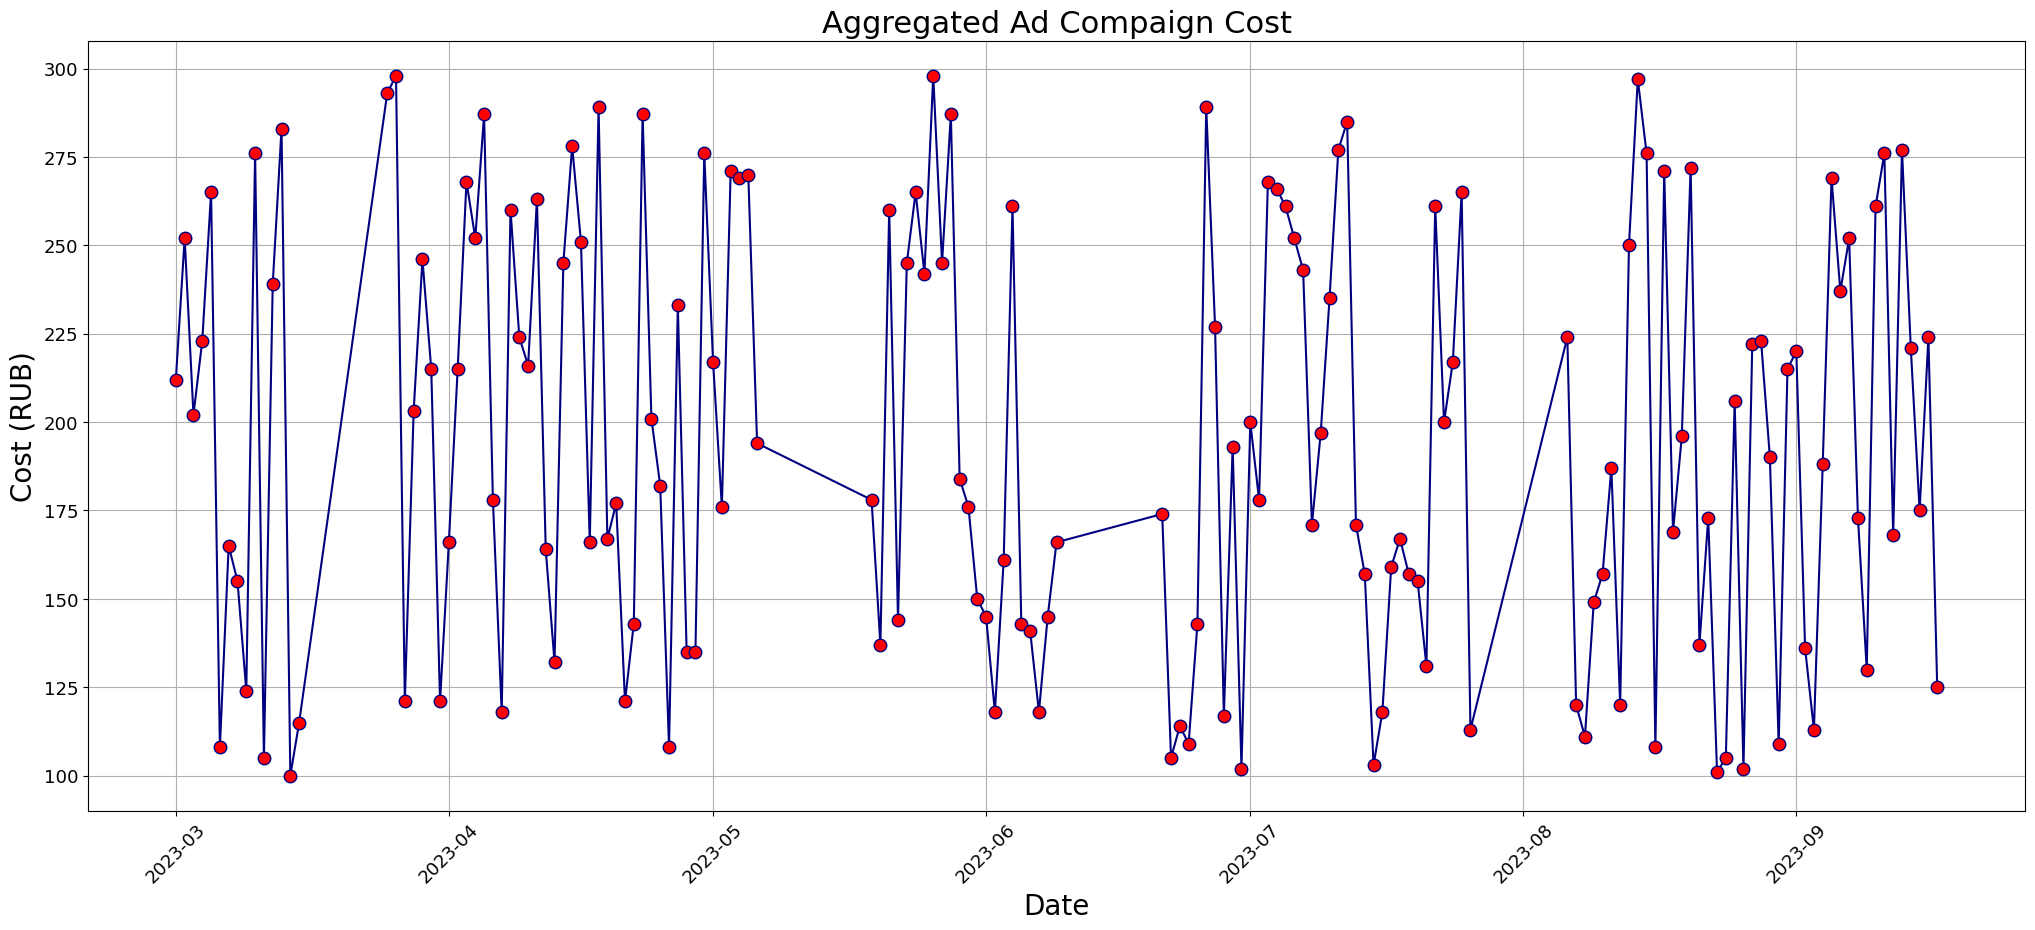

In [30]:
plt.figure(figsize=(25, 10))

plt.plot('date_group', 'cost', data=ads_graph, marker='o', color='navy', markersize=9, markerfacecolor='r')

plt.xlabel('Date', size=20)
plt.ylabel('Cost (RUB)', size=20)
plt.title('Aggregated Ad Compaign Cost', size=22)
plt.xticks(rotation=45, size=13)
plt.yticks(size=13)
plt.grid()

#for i, txt in enumerate(ads_graph['cost']):
    #plt.annotate(f'{txt}RUB', (ads_graph['date_group'][i], ads_graph['cost'][i]), 
                 #textcoords="offset points", xytext=(0,10), ha='center', size=16)

plt.savefig('./charts/ad_cost.png')
plt.show()

#### Количество визитов в активные рекламные дни

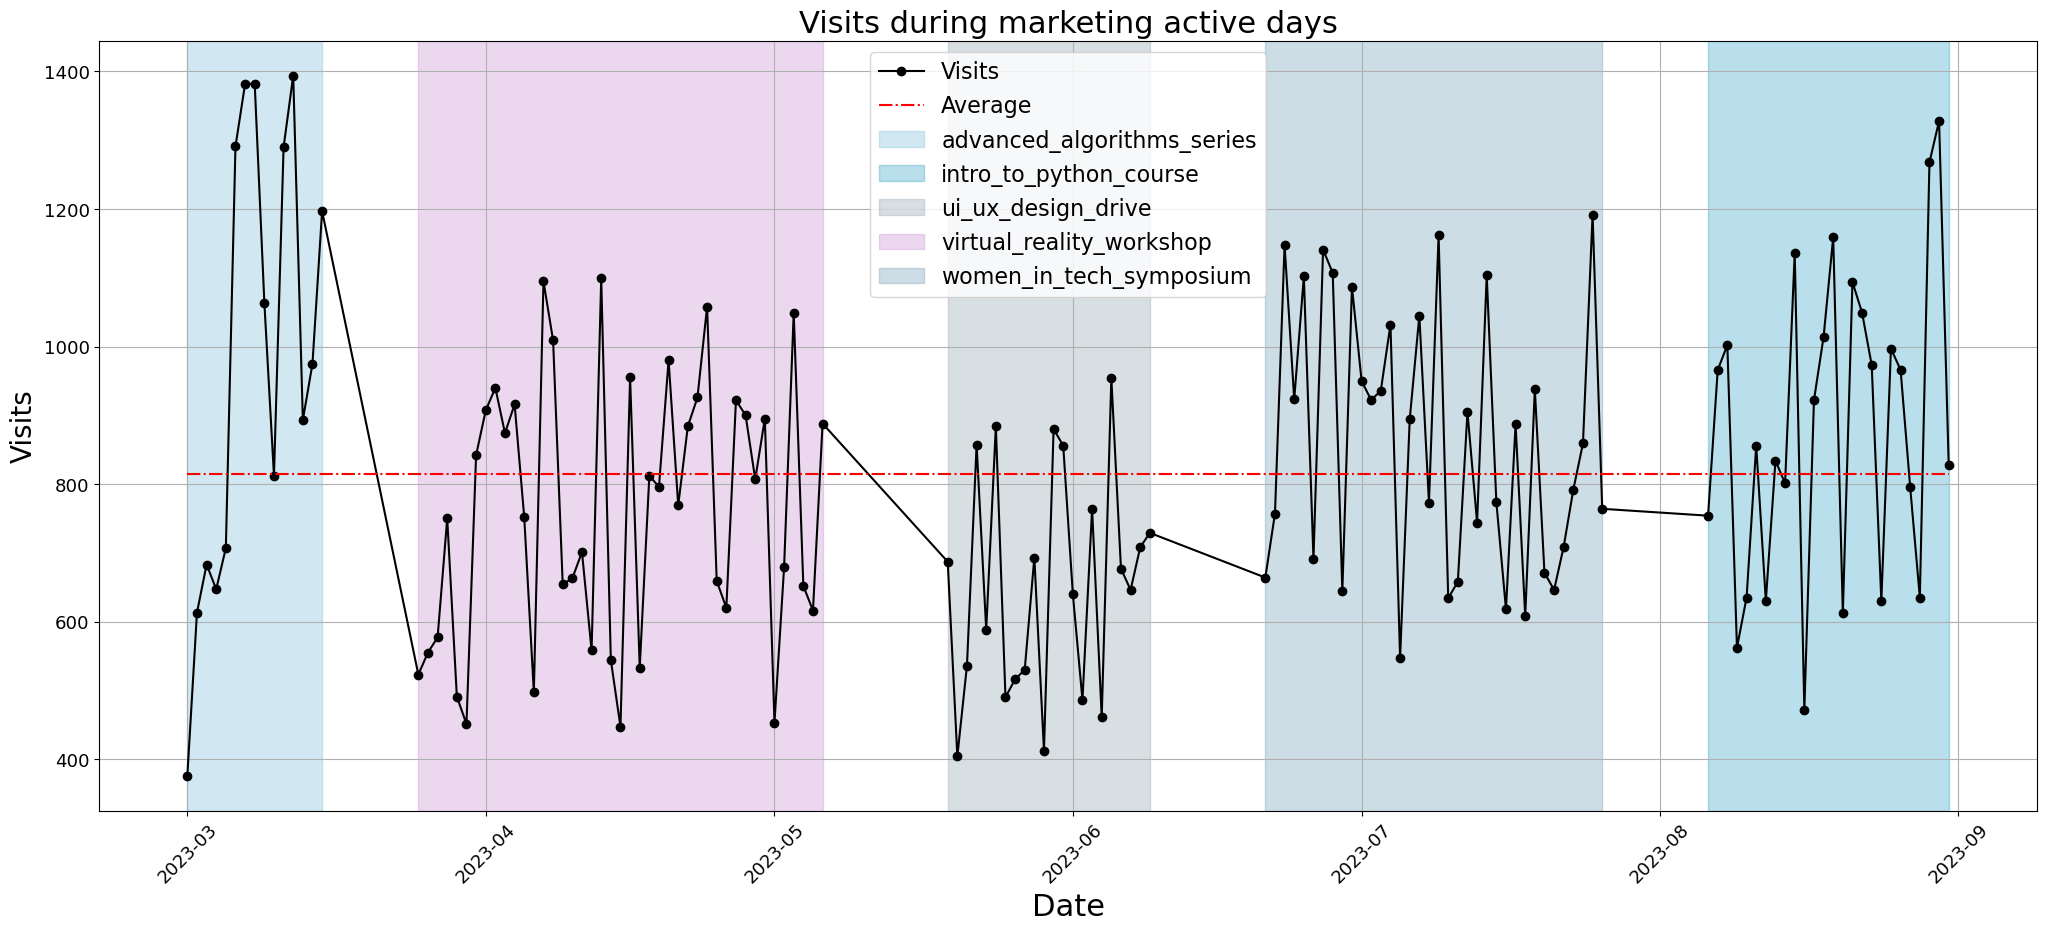

In [27]:
def market_graph(df, x, y, label, x_label, y_label, title):
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot(df[x], df[y], color='black', marker='o',label=label)
    ax.plot(df[x], df['average'], color='r', linestyle = '-.', label='Average')

    plt.xlabel(x_label, size=22)
    plt.ylabel(y_label, size=20)
    plt.title(title, size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    utm_started = utm['first'].to_list()
    utm_ended = utm['last'].to_list()
    for i in range(len(utm)):
        ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

    plt.legend(fontsize=16)

market_graph(vis_ads_utm, 'date_group', 'visits', 'Visits', 'Date', 'Visits', 
             'Visits during marketing active days')

plt.savefig('./charts/visits_during_marketing.png')
plt.show()

#### Количество регистраций в активные рекламные дни

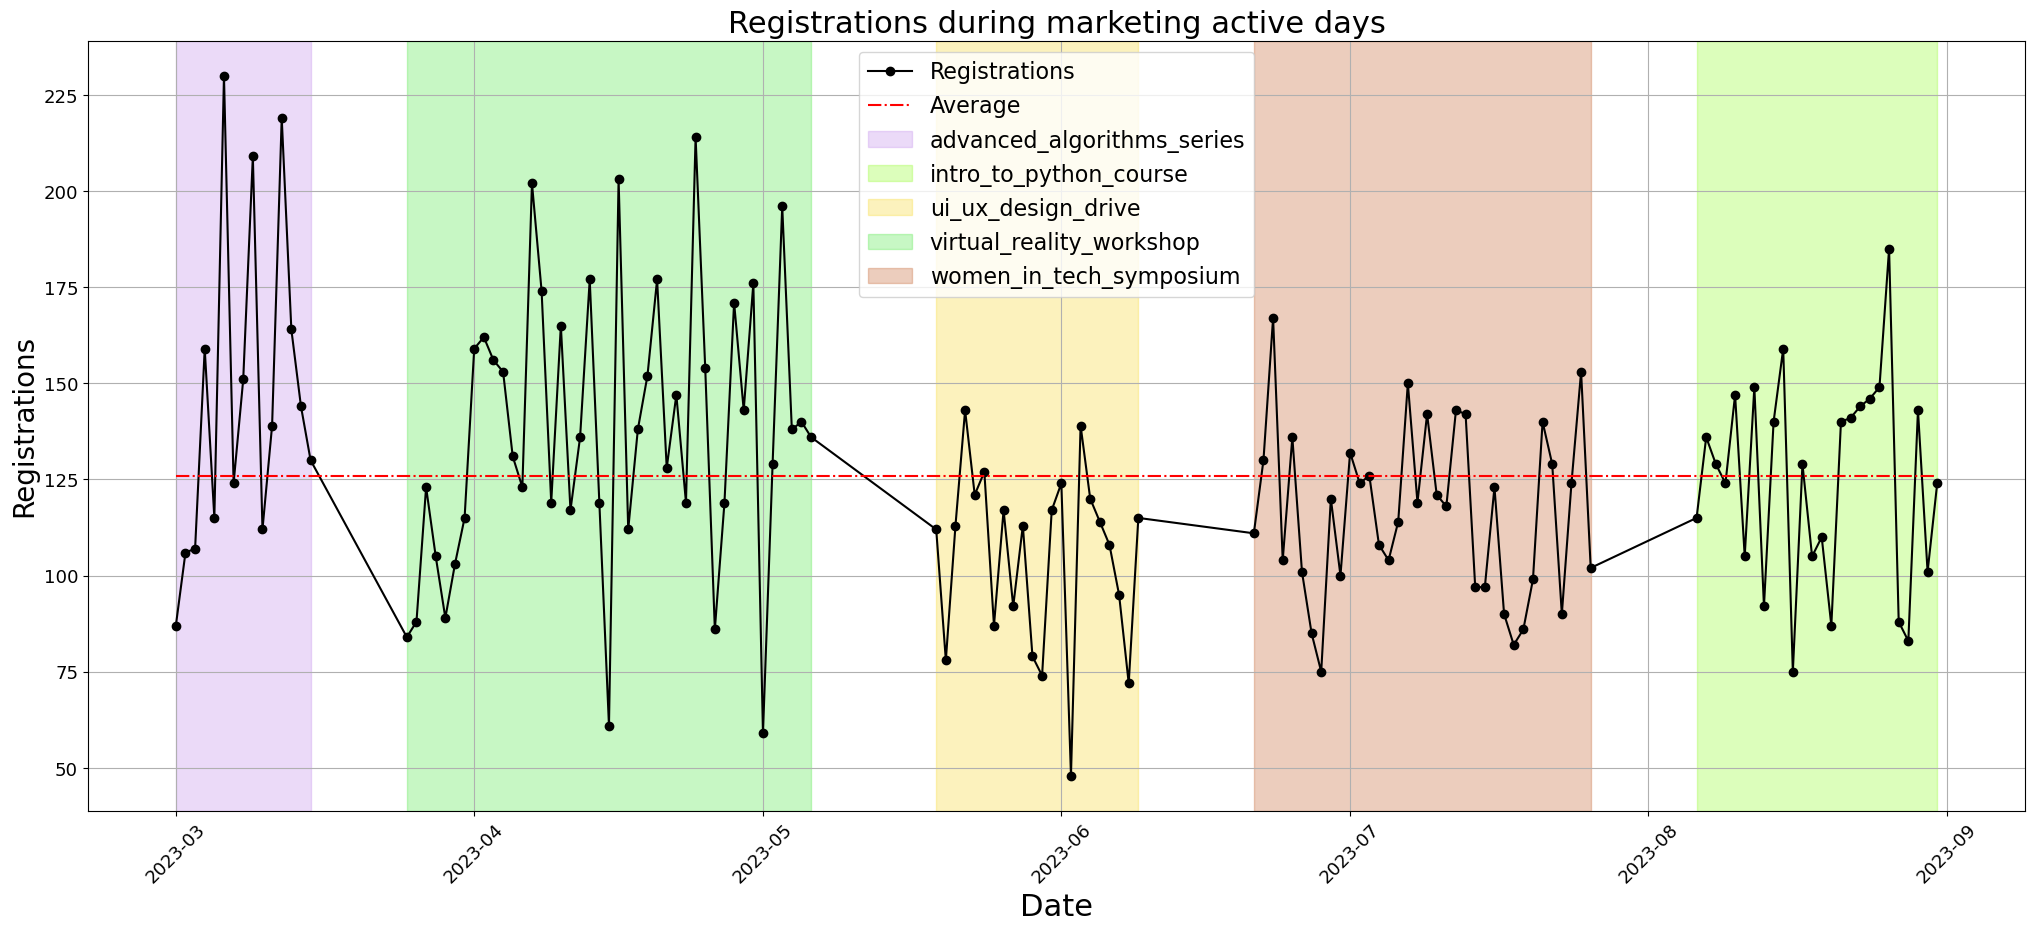

In [29]:
market_graph(reg_ads_utm, 'date_group', 'registrations', 'Registrations', 'Date', 'Registrations', 
             'Registrations during marketing active days')

plt.savefig('./charts/registrations_during_marketing.png')
plt.show()